# Coursework: Mammographic density prediction

In this coursework, you will implement a model for breast tissue density prediction from digital screening mammography data. Mammograms are X‑ray images acquired as part of regular breast cancer screening programmes. Breast tissue density is an important risk factor and is categorised into four classes according to the BI‑RADS (Breast Imaging Reporting and Data System) standard:
- Class A – Almost entirely fatty: The breast is composed mostly of fatty tissue with minimal fibroglandular density.
- Class B – Scattered areas of fibroglandular density: There are some dense areas, but most of the tissue is still fatty.
- Class C – Heterogeneously dense: Many areas of dense tissue are present, which may obscure small masses.
- Class D – Extremely dense: The breast is composed predominantly of dense tissue, making mammographic interpretation and cancer detection more challenging.

Your task is to develop and evaluate a predictive model capable of automatically assigning these density categories from mammographic images. You will be asked to assess the performance of the model across different subgroups, and conduct a model inspection using dimensionality reduction of feature embeddings.

The coursework is divided in the following parts:

* **Part A**: Choose a sensible data augmentation pipeline within the `MammoDataset` class.
* **Part B**: Implement a sensible model for image classification within the `MammoNet` class.
* **Part C**: Conduct a subgroup performance analysis.
* **Part D**: Inspect the trained model by analysing feature embeddings.
* **Part E**: Write a short report about your coursework (using the [provided template](https://www.overleaf.com/read/rkjxjntdfdwr#df7c9e)).

**Important:** Read the text descriptions carefully and look out for hints and comments indicating a specific **TASK**. Make sure to add sufficient documentation and comments to your code.

**Submission:** You are asked to submit two files:
1. You should submit this notebook in `.ipynb` format with *all outputs included*. Please name your file `notebook.ipynb`.
2. You should also submit a short report in `.pdf` format, using [this template](https://www.overleaf.com/read/rkjxjntdfdwr#df7c9e). Please name this file `report.pdf`.

### Your details

Please add your details below. You can work in groups up to two.

Authors: **Haiwei Luo** & **Alisa Chekalina**

DoC username: **hl2325** & **ac4325**

### Setup

In [ ]:
# On Google Colab uncomment the following line to install additional libraries
# ! pip install lightning
# ! pip install stocaching

# See the requirements.txt file for more details on the required libraries.
# We recommend using a virtual environment to manage dependencies.
# For example, you can create a virtual environment using venv:
# python3 -m venv myenv
# source myenv/bin/activate
# pip install -r requirements.txt

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as T
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

from matplotlib import cm
from ipywidgets import Output, HBox
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import decomposition
from sklearn.manifold import TSNE
from skimage.io import imread
from skimage.util import img_as_ubyte
from torchmetrics.functional import auroc
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from stocaching import SharedCache
from torchsampler import ImbalancedDatasetSampler

### Data

We make use of the publicly available [RSNA-SMBC dataset](https://registry.opendata.aws/rsna-screening-mammography-breast-cancer-detection/). We have preproceesed this dataset to make it easier to work with. We have reduced the image sizes to 128x96 and simplified the meta information.

Note, unzipping the dataset will take a few minutes, as there almost 30,000 images. Only needs to be done once.

In [6]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/rsna-small.zip
! unzip -q rsna-small.zip # Remove -q for verbose output

--2026-02-09 18:45:58--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/rsna-small.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285622253 (272M) [application/zip]
Saving to: ‘rsna-small.zip.2’

rsna-small.zip.2    100%[===================>] 272.39M  22.2MB/s    in 14s     

2026-02-09 18:46:12 (19.6 MB/s) - ‘rsna-small.zip.2’ saved [285622253/285622253]



In [4]:
DATA_DIR = './data/rsna-small'
CSV_FILE = os.path.join(DATA_DIR, 'meta.csv')
IMAGE_SIZE = (128, 96)
NUM_CLASSES = 4

Let's check the meta information of the dataset.

In [5]:
df_meta = pd.read_csv(CSV_FILE)
df_meta.head()

,image_id,laterality,view,age,cancer,implant,density,machine_id,study_id,split
0,1967300488,L,MLO,60.0,0,0,C,216,10038,training
1,2142944869,L,CC,60.0,0,0,C,216,10038,training
2,850559196,R,MLO,60.0,0,0,C,216,10038,training
3,1350492010,R,CC,60.0,0,0,C,216,10038,training
4,102733848,L,CC,51.0,0,0,C,93,10042,training


Let's visualise some random samples from each density class. You can run this cell repeatedly to see different samples.

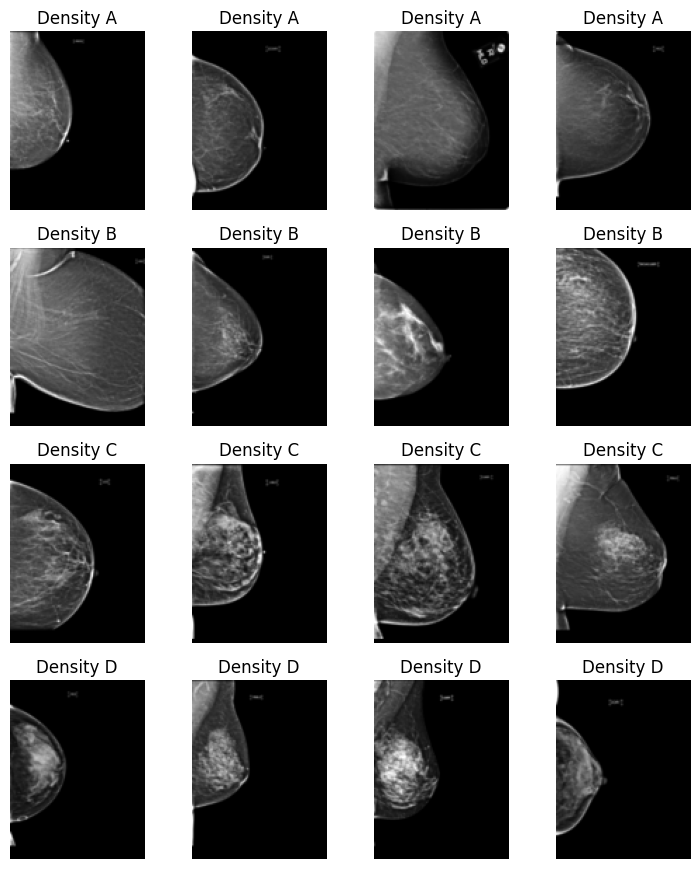

In [6]:
N_PER_CLASS = 4  # Number of images per class to display
CLASSES_DISPLAY = ["A", "B", "C", "D"] # Breast density classes for display

df_meta["img_path"] = [
    os.path.join(
        DATA_DIR, "images",
        str(df_meta.study_id.values[i]),
        str(df_meta.image_id.values[i]) + ".png"
    )
    for i in range(len(df_meta))
]

# display sample images from each class
fig, axes = plt.subplots(len(CLASSES_DISPLAY), N_PER_CLASS, figsize=(1.9 * N_PER_CLASS, 2.2 * len(CLASSES_DISPLAY)))
if N_PER_CLASS == 1: # In case of single column, expand dims
    axes = np.expand_dims(axes, axis=1)

for r, cls in enumerate(CLASSES_DISPLAY):
    sub = df_meta[df_meta["density"] == cls]
    k = min(N_PER_CLASS, len(sub))
    sample_idx = np.random.choice(len(sub), size=k, replace=False)
    samples = sub.iloc[sample_idx]
    for c in range(N_PER_CLASS):
        ax = axes[r, c]
        ax.axis("off")
        if c < k:
            img = imread(samples.iloc[c]["img_path"])
            ax.imshow(img, cmap="gray")
            ax.set_title(f"Density {cls}", fontsize=12)
plt.tight_layout()
plt.show()


## **Part A**: Choose a sensible data augmentation pipeline within the `MammoDataset` class.

We provide a custom [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) that manages the RSNA-SMBC dataset.

**TASK:** Implement data augmentation for mammography images. You can use the `torchvision.transforms.v2` module to select a sensible set of photometric and geometric transformations. Report your choices in the coursework report.

In [7]:
class MammoDataset(Dataset):
    def __init__(self, data, image_size, image_normalization, augmentation = False, cache_size = 0):
        self.image_normalization = image_normalization
        self.do_augment = augmentation

        # photometric data augmentation
        self.photometric_augment = T.Compose([
            T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
            T.RandomApply([T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.2),
            T.RandomApply([T.GaussianNoise(mean=0.0, sigma=0.03, clip=True)], p=0.2),
        ])

        # geometric data augmentation
        self.geometric_augment = T.Compose([
            T.RandomApply(transforms=[T.RandomAffine(degrees=5, scale=(0.9, 1.1), interpolation=T.InterpolationMode.NEAREST)], p=0.5),
        ])

        # load metadata into numpy arrays for faster access
        self.img_paths = data.img_path.to_numpy()
        self.study_ids = data.study_id.to_numpy()
        self.image_ids = data.image_id.to_numpy()
        self.labels = data.labels.to_numpy()

        # cache for preprocessed images to speed up training after the first epoch
        self.cache = None
        self.use_cache = cache_size > 0
        if self.use_cache:
            self.cache = SharedCache(
                size_limit_gib=cache_size,
                dataset_len=self.labels.shape[0],
                data_dims=(1, image_size[0], image_size[1]),
                dtype=torch.float32,
            )

    def preprocess(self, image):
        # breast segmentation using connected components
        image_norm = image - np.min(image)
        image_norm = image_norm / np.max(image_norm)
        thresh = cv2.threshold(img_as_ubyte(image_norm), 5, 255, cv2.THRESH_BINARY)[1]
        nb_components, output, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=4)

        # Find the largest non background component.
        max_label, _ = max(
            [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)],
            key=lambda x: x[1],
        )
        mask = output == max_label
        image[mask == 0] = 0
                
        return image

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        image = None
        if self.use_cache:
            image = self.cache.get_slot(index)
        
        if image is None:
            img_path = self.img_paths[index]
            image = imread(img_path).astype(np.float32)
            image = self.preprocess(image)
            image = torch.from_numpy(image).unsqueeze(0)            
            
            if self.use_cache:
                self.cache.set_slot(index, image, allow_overwrite=True)

        # normalize intensities to range [0,1]
        image = image / self.image_normalization

        if self.do_augment:
            image = self.photometric_augment(image)
            image = self.geometric_augment(image)

        # convert to 3-channel image to be compatible with pretrained models
        image = image.repeat(3, 1, 1)

        return {'image': image, 'label': self.labels[index], 'study_id': self.study_ids[index], 'image_id': self.image_ids[index]}
    
    def get_labels(self):
        return self.labels


We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for preparing the RSNA-SMBC dataset and its training, validation and test splits. No changes required here but make sure that you understand what is happening within this module.

In [8]:
class MammoDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, csv_file, image_size, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        # load metadata
        self.data = pd.read_csv(csv_file)

        # construct image paths from metadata
        self.data['img_path'] = [os.path.join(self.data_dir, 'images', str(self.data.study_id.values[idx]), str(self.data.image_id.values[idx]) + '.png') for idx in range(0, len(self.data))]

        # Define image labels based on breast density classes
        self.data['labels'] = self.data['density']
        self.data.loc[self.data['labels'] == 'A', 'labels'] = 0
        self.data.loc[self.data['labels'] == 'B', 'labels'] = 1
        self.data.loc[self.data['labels'] == 'C', 'labels'] = 2
        self.data.loc[self.data['labels'] == 'D', 'labels'] = 3

        # Use pre-defined splits to separate data into train, val and testing
        self.train_data = self.data[self.data['split'] == 'training']
        self.val_data = self.data[self.data['split'] == 'validation']
        self.test_data = self.data[self.data['split'] == 'test']

        # create dataset objects for each split
        self.train_set = MammoDataset(self.train_data, self.image_size, image_normalization=65535.0, augmentation=True, cache_size=2)
        self.val_set = MammoDataset(self.val_data, self.image_size, image_normalization=65535.0, augmentation=False, cache_size=0.5)
        self.test_set = MammoDataset(self.test_data, self.image_size, image_normalization=65535.0, augmentation=False)

        # print dataset statistics
        train_labels = self.train_set.get_labels()
        train_class_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])

        val_labels = self.val_set.get_labels()        
        val_class_count = np.array([len(np.where(val_labels == t)[0]) for t in np.unique(val_labels)])

        test_labels = self.test_set.get_labels()        
        test_class_count = np.array([len(np.where(test_labels == t)[0]) for t in np.unique(test_labels)])

        print('samples (train): ',len(self.train_set))
        print('samples (val):   ',len(self.val_set))
        print('samples (test):  ',len(self.test_set))
        print('class counts (train): ', train_class_count)
        print('class counts (val):   ', val_class_count)
        print('class counts (test):  ', test_class_count)
        print('class % (train): ', np.array([f"{x:.2f}" for x in np.array(train_class_count/len(train_labels)*100.0)]))
        print('class % (val):   ', np.array([f"{x:.2f}" for x in np.array(val_class_count/len(val_labels)*100.0)]))
        print('class % (test):  ', np.array([f"{x:.2f}" for x in np.array(test_class_count/len(test_labels)*100.0)]))

    def train_dataloader(self):
        # we use ImbalancedDatasetSampler to handle class imbalance in the training set
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, sampler=ImbalancedDatasetSampler(self.train_set), num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

## **Part B**: Implement a sensible model for image classification within the `MammoNet` class.

We use a [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for implementing the model and its training and testing steps.

**TASK:** Implement and try out different models suitable for the breast density prediction problem. Check out the `torchvision.models` module. Report your choices in the coursework report.

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights

class MammoNet(pl.LightningModule):

    def __init__(self, num_classes, learning_rate=1e-3, pretrained=True, freeze_features=False):
        super().__init__()
        self.num_classes = num_classes
        self.lr = learning_rate

        weights = SqueezeNet1_1_Weights.DEFAULT if pretrained else None
        self.model = squeezenet1_1(weights=weights)  # :contentReference[oaicite:1]{index=1}

        # Replace classifier conv: Conv2d(512 -> 1000) becomes Conv2d(512 -> num_classes)
        self.model.classifier[1] = nn.Conv2d(
            in_channels=512,
            out_channels=num_classes,
            kernel_size=1
        )
        # (Optional) update metadata
        self.model.num_classes = num_classes

        if freeze_features:
            for p in self.model.features.parameters():
                p.requires_grad = False

        # Optional: recommended preprocessing for pretrained weights
        self.preprocess = weights.transforms() if weights is not None else None  # :contentReference[oaicite:2]{index=2}

    def forward(self, x):
        return self.model(x)  # logits (N, num_classes)

    def configure_optimizers(self):
        return torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.lr
        )

    def process_batch(self, batch):
        img, lab = batch['image'], batch['label']
        out = self(img)
        prd = torch.softmax(out, dim=1)
        loss = F.cross_entropy(out, lab)
        return loss, prd, lab


    def __init__(self, num_classes, learning_rate=1e-4, pretrained=True, freeze_backbone=False):
        super().__init__()
        self.num_classes = num_classes
        self.lr = learning_rate

        # Build ResNet
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        self.model = resnet18(weights=weights)  # weights=... is the current API :contentReference[oaicite:1]{index=1}

        # Replace the classifier head
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # Optional: freeze feature extractor (train only the new head)
        if freeze_backbone:
            for p in self.model.parameters():
                p.requires_grad = False
            for p in self.model.fc.parameters():
                p.requires_grad = True

        # Optional: recommended preprocessing for pretrained weights
        # self.preprocess = weights.transforms() if weights is not None else None :contentReference[oaicite:2]{index=2}

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.lr
        )
        return optimizer

    def process_batch(self, batch):
        img, lab = batch['image'], batch['label']
        out = self(img)                      # logits
        prd = torch.softmax(out, dim=1)
        loss = F.cross_entropy(out, lab)
        return loss, prd, lab
   
    
    # def __init__(self, num_classes, learning_rate=0.0001):
    #     super().__init__()
    #     self.num_classes = num_classes
    #     self.lr = learning_rate

        # # naive two-layer MLP model
        # self.model = nn.Sequential(
        #     nn.Linear(torch.prod(torch.tensor(IMAGE_SIZE)) * 3, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, self.num_classes)
        # )


    #     self.conv = nn.Sequential(
    #         nn.Conv2d(3, 6, kernel_size=5),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2),
    #         nn.Conv2d(6, 16, kernel_size=5),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2)
    #         )
        
    #     with torch.no_grad():
    #         dummy = torch.zeros(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])
    #         conv_out = self.conv(dummy)
    #         flat_dim = conv_out.shape[1] * conv_out.shape[2] * conv_out.shape[3]

    #     self.fc = nn.Sequential(
    #         nn.Linear(flat_dim, 120),
    #         nn.ReLU(inplace=True),
    #         nn.Linear(120, 84),
    #         nn.ReLU(inplace=True),
    #         nn.Linear(84, num_classes),
    #     )
        
        
        
    # def forward(self, x):
    #     # x = x.view(x.size(0), -1) # flatten the input image
    #     # return self.model(x)
    
    #     x = self.conv(x)
    #     x = x.view(x.size(0), -1)
    #     # then pass linearised x through the fully connected layers
    #     return self.fc(x)

    # def configure_optimizers(self):
    #     # optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    #     optimizer = torch.optim.Adam(self.fc.parameters(), lr=self.lr)
    #     return optimizer

    # def process_batch(self, batch):
    #     img, lab = batch['image'], batch['label']
    #     out = self.forward(img)
    #     prd = torch.softmax(out, dim=1)
    #     loss = F.cross_entropy(out, lab)
    #     return loss, prd, lab

    def on_train_epoch_start(self):
        self.train_preds = []
        self.train_trgts = []

    def training_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('train_loss', loss, batch_size=lab.shape[0])
        self.train_preds.append(prd.detach().cpu())
        self.train_trgts.append(lab.detach().cpu())
        if batch_idx == 0:
            images = batch['image'][0:4, ...].detach().cpu()
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True)
            self.logger.experiment.add_image('images', grid, self.global_step)
        return loss

    def on_train_epoch_end(self):
        self.train_preds = torch.cat(self.train_preds, dim=0)
        self.train_trgts = torch.cat(self.train_trgts, dim=0)
        auc = auroc(self.train_preds, self.train_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('train_auc', auc)
        self.train_preds = []
        self.train_trgts = []

    def on_validation_epoch_start(self):
        self.val_preds = []
        self.val_trgts = []

    def validation_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('val_loss', loss, batch_size=lab.shape[0])
        self.val_preds.append(prd.detach().cpu())
        self.val_trgts.append(lab.detach().cpu())

    def on_validation_epoch_end(self):
        self.val_preds = torch.cat(self.val_preds, dim=0)
        self.val_trgts = torch.cat(self.val_trgts, dim=0)
        auc = auroc(self.val_preds, self.val_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('val_auc', auc)
        self.val_preds = []
        self.val_trgts = []

    def on_test_epoch_start(self):
        self.test_preds = []
        self.test_trgts = []
        self.test_study_ids = []
        self.test_image_ids = []

    def test_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('test_loss', loss, batch_size=lab.shape[0])
        self.test_preds.append(prd.detach().cpu())
        self.test_trgts.append(lab.detach().cpu())        
        self.test_study_ids.append(batch['study_id'].detach().cpu())
        self.test_image_ids.append(batch['image_id'].detach().cpu())

    def on_test_epoch_end(self):
        self.test_preds = torch.cat(self.test_preds, dim=0)
        self.test_trgts = torch.cat(self.test_trgts, dim=0)
        auc = auroc(self.test_preds, self.test_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('test_auc', auc)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision
from torchmetrics.functional import auroc


# =========================================================
# 1️⃣ Basic Residual Block
# =========================================================
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()

        # If dimensions change → projection shortcut
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = F.relu(out)

        return out


# =========================================================
# 2️⃣ Naive ResNet-18
# =========================================================
class NaiveResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super().__init__()

        self.in_channels = 64

        # Initial stem
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=7,
            stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1
        )

        # Residual layers
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []

        # First block (may downsample)
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# =========================================================
# 3️⃣ Lightning Module
# =========================================================
class MammoNet(pl.LightningModule):

    def __init__(self, num_classes, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.num_classes = num_classes
        self.lr = learning_rate

        self.model = NaiveResNet(
            block=BasicBlock,
            num_blocks=[2, 2, 2, 2],
            num_classes=num_classes
        )

        # ✅ Add these lines
        self.test_preds = []
        self.test_trgts = []
        self.test_study_ids = []
        self.test_image_ids = []

    # -----------------------------------------------------
    # Forward
    # -----------------------------------------------------
    def forward(self, x):
        return self.model(x)

    # -----------------------------------------------------
    # Optimizer
    # -----------------------------------------------------
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    # -----------------------------------------------------
    # Shared batch processing
    # -----------------------------------------------------
    def process_batch(self, batch):
        img, lab = batch['image'], batch['label']
        logits = self(img)
        probs = torch.softmax(logits, dim=1)
        loss = F.cross_entropy(logits, lab)
        return loss, probs, lab

    # =====================================================
    # TRAINING
    # =====================================================
    def on_train_epoch_start(self):
        self.train_preds = []
        self.train_trgts = []

    def training_step(self, batch, batch_idx):
        loss, probs, lab = self.process_batch(batch)

        self.log("train_loss", loss, batch_size=lab.size(0))

        self.train_preds.append(probs.detach().cpu())
        self.train_trgts.append(lab.detach().cpu())

        # Log example images
        if batch_idx == 0:
            images = batch['image'][0:4].detach().cpu()
            grid = torchvision.utils.make_grid(
                images, nrow=2, normalize=True
            )
            self.logger.experiment.add_image(
                "train_images", grid, self.global_step
            )

        return loss

    def on_train_epoch_end(self):
        preds = torch.cat(self.train_preds)
        trgts = torch.cat(self.train_trgts)

        auc = auroc(
            preds, trgts,
            task="multiclass",
            num_classes=self.num_classes,
            average="macro"
        )

        self.log("train_auc", auc)

    # =====================================================
    # VALIDATION
    # =====================================================
    def on_validation_epoch_start(self):
        self.val_preds = []
        self.val_trgts = []

    def validation_step(self, batch, batch_idx):
        loss, probs, lab = self.process_batch(batch)

        self.log("val_loss", loss, batch_size=lab.size(0))

        self.val_preds.append(probs.detach().cpu())
        self.val_trgts.append(lab.detach().cpu())

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_preds)
        trgts = torch.cat(self.val_trgts)

        auc = auroc(
            preds, trgts,
            task="multiclass",
            num_classes=self.num_classes,
            average="macro"
        )

        self.log("val_auc", auc)

    # =====================================================
    # TEST
    # =====================================================
    def on_test_epoch_start(self):
        self.test_preds = []
        self.test_trgts = []

    def test_step(self, batch, batch_idx):
        loss, probs, lab = self.process_batch(batch)

        self.log("test_loss", loss, batch_size=lab.size(0))

        self.test_preds.append(probs.detach().cpu())
        self.test_trgts.append(lab.detach().cpu())

    def on_test_epoch_end(self):
        preds = torch.cat(self.test_preds)
        trgts = torch.cat(self.test_trgts)

        auc = auroc(
            preds, trgts,
            task="multiclass",
            num_classes=self.num_classes,
            average="macro"
        )

        self.log("test_auc", auc)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from torchvision.models import resnet18, ResNet18_Weights

class MammoNet(pl.LightningModule):

    def __init__(self, num_classes, learning_rate=1e-4, pretrained=True, freeze_backbone=False):
        super().__init__()
        self.num_classes = num_classes
        self.lr = learning_rate

        # Build ResNet
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        self.model = resnet18(weights=weights)  # weights=... is the current API :contentReference[oaicite:1]{index=1}

        # Replace the classifier head
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # Optional: freeze feature extractor (train only the new head)
        if freeze_backbone:
            for p in self.model.parameters():
                p.requires_grad = False
            for p in self.model.fc.parameters():
                p.requires_grad = True


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.lr
        )
        return optimizer

    def process_batch(self, batch):
        img, lab = batch['image'], batch['label']
        out = self(img)                      # logits
        prd = torch.softmax(out, dim=1)
        loss = F.cross_entropy(out, lab)
        return loss, prd, lab
   
    
    # def __init__(self, num_classes, learning_rate=0.0001):
    #     super().__init__()
    #     self.num_classes = num_classes
    #     self.lr = learning_rate

        # # naive two-layer MLP model
        # self.model = nn.Sequential(
        #     nn.Linear(torch.prod(torch.tensor(IMAGE_SIZE)) * 3, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, self.num_classes)
        # )


    #     self.conv = nn.Sequential(
    #         nn.Conv2d(3, 6, kernel_size=5),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2),
    #         nn.Conv2d(6, 16, kernel_size=5),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2)
    #         )
        
    #     with torch.no_grad():
    #         dummy = torch.zeros(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])
    #         conv_out = self.conv(dummy)
    #         flat_dim = conv_out.shape[1] * conv_out.shape[2] * conv_out.shape[3]

    #     self.fc = nn.Sequential(
    #         nn.Linear(flat_dim, 120),
    #         nn.ReLU(inplace=True),
    #         nn.Linear(120, 84),
    #         nn.ReLU(inplace=True),
    #         nn.Linear(84, num_classes),
    #     )
        
        
        
    # def forward(self, x):
    #     # x = x.view(x.size(0), -1) # flatten the input image
    #     # return self.model(x)
    
    #     x = self.conv(x)
    #     x = x.view(x.size(0), -1)
    #     # then pass linearised x through the fully connected layers
    #     return self.fc(x)

    # def configure_optimizers(self):
    #     # optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    #     optimizer = torch.optim.Adam(self.fc.parameters(), lr=self.lr)
    #     return optimizer

    # def process_batch(self, batch):
    #     img, lab = batch['image'], batch['label']
    #     out = self.forward(img)
    #     prd = torch.softmax(out, dim=1)
    #     loss = F.cross_entropy(out, lab)
    #     return loss, prd, lab

    def on_train_epoch_start(self):
        self.train_preds = []
        self.train_trgts = []

    def training_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('train_loss', loss, batch_size=lab.shape[0])
        self.train_preds.append(prd.detach().cpu())
        self.train_trgts.append(lab.detach().cpu())
        if batch_idx == 0:
            images = batch['image'][0:4, ...].detach().cpu()
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True)
            self.logger.experiment.add_image('images', grid, self.global_step)
        return loss

    def on_train_epoch_end(self):
        self.train_preds = torch.cat(self.train_preds, dim=0)
        self.train_trgts = torch.cat(self.train_trgts, dim=0)
        auc = auroc(self.train_preds, self.train_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('train_auc', auc)
        self.train_preds = []
        self.train_trgts = []

    def on_validation_epoch_start(self):
        self.val_preds = []
        self.val_trgts = []

    def validation_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('val_loss', loss, batch_size=lab.shape[0])
        self.val_preds.append(prd.detach().cpu())
        self.val_trgts.append(lab.detach().cpu())

    def on_validation_epoch_end(self):
        self.val_preds = torch.cat(self.val_preds, dim=0)
        self.val_trgts = torch.cat(self.val_trgts, dim=0)
        auc = auroc(self.val_preds, self.val_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('val_auc', auc)
        self.val_preds = []
        self.val_trgts = []

    def on_test_epoch_start(self):
        self.test_preds = []
        self.test_trgts = []
        self.test_study_ids = []
        self.test_image_ids = []

    def test_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('test_loss', loss, batch_size=lab.shape[0])
        self.test_preds.append(prd.detach().cpu())
        self.test_trgts.append(lab.detach().cpu())        
        self.test_study_ids.append(batch['study_id'].detach().cpu())
        self.test_image_ids.append(batch['image_id'].detach().cpu())

    def on_test_epoch_end(self):
        self.test_preds = torch.cat(self.test_preds, dim=0)
        self.test_trgts = torch.cat(self.test_trgts, dim=0)
        auc = auroc(self.test_preds, self.test_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('test_auc', auc)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from torchvision.models import googlenet, GoogLeNet_Weights

class MammoNet(pl.LightningModule):

    def __init__(self, num_classes, learning_rate=1e-4, pretrained=True, aux_logits=True):
        super().__init__()
        self.num_classes = num_classes
        self.lr = learning_rate
        self.aux_logits = aux_logits

        weights = GoogLeNet_Weights.DEFAULT if pretrained else None
        self.model = googlenet(weights=weights, aux_logits=aux_logits)

        # Replace final classifier
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # If you keep auxiliary heads, also replace their classifiers
        if aux_logits and self.model.aux1 is not None and self.model.aux2 is not None:
            self.model.aux1.fc2 = nn.Linear(self.model.aux1.fc2.in_features, num_classes)
            self.model.aux2.fc2 = nn.Linear(self.model.aux2.fc2.in_features, num_classes)

        # handy if you want the canonical preprocessing for pretrained weights
        self.preprocess = weights.transforms() if weights is not None else None

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def process_batch(self, batch):
        img, lab = batch["image"], batch["label"]
        out = self(img)

        # training mode + aux_logits=True => out has .logits, .aux_logits1, .aux_logits2
        if hasattr(out, "logits"):
            logits = out.logits
            loss = F.cross_entropy(logits, lab)
            if out.aux_logits1 is not None:
                loss = loss + 0.3 * F.cross_entropy(out.aux_logits1, lab)
            if out.aux_logits2 is not None:
                loss = loss + 0.3 * F.cross_entropy(out.aux_logits2, lab)
        else:
            logits = out
            loss = F.cross_entropy(logits, lab)

        prd = torch.softmax(logits, dim=1)
        return loss, prd, lab
   
    
    # def __init__(self, num_classes, learning_rate=0.0001):
    #     super().__init__()
    #     self.num_classes = num_classes
    #     self.lr = learning_rate

        # # naive two-layer MLP model
        # self.model = nn.Sequential(
        #     nn.Linear(torch.prod(torch.tensor(IMAGE_SIZE)) * 3, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, self.num_classes)
        # )


    #     self.conv = nn.Sequential(
    #         nn.Conv2d(3, 6, kernel_size=5),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2),
    #         nn.Conv2d(6, 16, kernel_size=5),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2)
    #         )
        
    #     with torch.no_grad():
    #         dummy = torch.zeros(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])
    #         conv_out = self.conv(dummy)
    #         flat_dim = conv_out.shape[1] * conv_out.shape[2] * conv_out.shape[3]

    #     self.fc = nn.Sequential(
    #         nn.Linear(flat_dim, 120),
    #         nn.ReLU(inplace=True),
    #         nn.Linear(120, 84),
    #         nn.ReLU(inplace=True),
    #         nn.Linear(84, num_classes),
    #     )
        
        
        
    # def forward(self, x):
    #     # x = x.view(x.size(0), -1) # flatten the input image
    #     # return self.model(x)
    
    #     x = self.conv(x)
    #     x = x.view(x.size(0), -1)
    #     # then pass linearised x through the fully connected layers
    #     return self.fc(x)

    # def configure_optimizers(self):
    #     # optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    #     optimizer = torch.optim.Adam(self.fc.parameters(), lr=self.lr)
    #     return optimizer

    # def process_batch(self, batch):
    #     img, lab = batch['image'], batch['label']
    #     out = self.forward(img)
    #     prd = torch.softmax(out, dim=1)
    #     loss = F.cross_entropy(out, lab)
    #     return loss, prd, lab

    def on_train_epoch_start(self):
        self.train_preds = []
        self.train_trgts = []

    def training_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('train_loss', loss, batch_size=lab.shape[0])
        self.train_preds.append(prd.detach().cpu())
        self.train_trgts.append(lab.detach().cpu())
        if batch_idx == 0:
            images = batch['image'][0:4, ...].detach().cpu()
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True)
            self.logger.experiment.add_image('images', grid, self.global_step)
        return loss

    def on_train_epoch_end(self):
        self.train_preds = torch.cat(self.train_preds, dim=0)
        self.train_trgts = torch.cat(self.train_trgts, dim=0)
        auc = auroc(self.train_preds, self.train_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('train_auc', auc)
        self.train_preds = []
        self.train_trgts = []

    def on_validation_epoch_start(self):
        self.val_preds = []
        self.val_trgts = []

    def validation_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('val_loss', loss, batch_size=lab.shape[0])
        self.val_preds.append(prd.detach().cpu())
        self.val_trgts.append(lab.detach().cpu())

    def on_validation_epoch_end(self):
        self.val_preds = torch.cat(self.val_preds, dim=0)
        self.val_trgts = torch.cat(self.val_trgts, dim=0)
        auc = auroc(self.val_preds, self.val_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('val_auc', auc)
        self.val_preds = []
        self.val_trgts = []

    def on_test_epoch_start(self):
        self.test_preds = []
        self.test_trgts = []
        self.test_study_ids = []
        self.test_image_ids = []

    def test_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('test_loss', loss, batch_size=lab.shape[0])
        self.test_preds.append(prd.detach().cpu())
        self.test_trgts.append(lab.detach().cpu())        
        self.test_study_ids.append(batch['study_id'].detach().cpu())
        self.test_image_ids.append(batch['image_id'].detach().cpu())

    def on_test_epoch_end(self):
        self.test_preds = torch.cat(self.test_preds, dim=0)
        self.test_trgts = torch.cat(self.test_trgts, dim=0)
        auc = auroc(self.test_preds, self.test_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('test_auc', auc)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from torchvision.models import resnet18, ResNet18_Weights
from torchmetrics.functional import auroc


# =========================================================
# Custom ResNet18 (Manual Forward)
# =========================================================
class ResNet18(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()

        weights = ResNet18_Weights.DEFAULT if pretrained else None
        self.resnet = resnet18(weights=weights)

        # Replace final classifier
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)

        return x

    # def get_embeddings(self, x):
    #     x = self.resnet.conv1(x)
    #     x = self.resnet.bn1(x)
    #     x = self.resnet.relu(x)
    #     x = self.resnet.maxpool(x)

    #     x = self.resnet.layer1(x)
    #     x = self.resnet.layer2(x)
    #     x = self.resnet.layer3(x)
    #     x = self.resnet.layer4(x)

    #     x = self.resnet.avgpool(x)
    #     x = torch.flatten(x, 1)
    #     return x


# =========================================================
# Lightning Module
# =========================================================
class MammoNet(pl.LightningModule):

    def __init__(self, num_classes, learning_rate=1e-4, pretrained=True, freeze_backbone=False):
        super().__init__()

        self.save_hyperparameters()

        self.num_classes = num_classes
        self.lr = learning_rate

        # Use custom ResNet18
        self.model = ResNet18(
            num_classes=num_classes,
            pretrained=pretrained
        )

        # Optional freezing
        if freeze_backbone:
            for param in self.model.resnet.parameters():
                param.requires_grad = False

            # Unfreeze classifier
            for param in self.model.resnet.fc.parameters():
                param.requires_grad = True

        # Test storage
        self.test_preds = []
        self.test_trgts = []
        self.test_study_ids = []
        self.test_image_ids = []

    # -----------------------------------------------------
    # Forward
    # -----------------------------------------------------
    def forward(self, x):
        return self.model(x)

    # -----------------------------------------------------
    # Optimizer
    # -----------------------------------------------------
    def configure_optimizers(self):
        return torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.lr,
            weight_decay=1e-4
        )

    # -----------------------------------------------------
    # Shared Batch Logic
    # -----------------------------------------------------
    def process_batch(self, batch):
        img, lab = batch["image"], batch["label"]

        logits = self(img)
        probs = torch.softmax(logits, dim=1)
        loss = F.cross_entropy(logits, lab)

        return loss, probs, lab


    # =====================================================
    # TRAINING
    # =====================================================
    def on_train_epoch_start(self):
        self.train_preds = []
        self.train_trgts = []

    def training_step(self, batch, batch_idx):
        loss, probs, lab = self.process_batch(batch)

        self.log("train_loss", loss, batch_size=lab.shape[0])
        self.train_preds.append(probs.detach().cpu())
        self.train_trgts.append(lab.detach().cpu())

        if batch_idx == 0:
            images = batch["image"][0:4].detach().cpu()
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True)
            self.logger.experiment.add_image("images", grid, self.global_step)

        return loss

    def on_train_epoch_end(self):
        preds = torch.cat(self.train_preds, dim=0)
        trgts = torch.cat(self.train_trgts, dim=0)

        auc = auroc(
            preds,
            trgts,
            task="multiclass",
            num_classes=self.num_classes,
            average="macro"
        )

        self.log("train_auc", auc)

        self.train_preds = []
        self.train_trgts = []


    # =====================================================
    # VALIDATION
    # =====================================================
    def on_validation_epoch_start(self):
        self.val_preds = []
        self.val_trgts = []

    def validation_step(self, batch, batch_idx):
        loss, probs, lab = self.process_batch(batch)

        self.log("val_loss", loss, batch_size=lab.shape[0])
        self.val_preds.append(probs.detach().cpu())
        self.val_trgts.append(lab.detach().cpu())

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_preds, dim=0)
        trgts = torch.cat(self.val_trgts, dim=0)

        auc = auroc(
            preds,
            trgts,
            task="multiclass",
            num_classes=self.num_classes,
            average="macro"
        )

        self.log("val_auc", auc)

        self.val_preds = []
        self.val_trgts = []


    # =====================================================
    # TEST
    # =====================================================
    def on_test_epoch_start(self):
        self.test_preds = []
        self.test_trgts = []
        self.test_study_ids = []
        self.test_image_ids = []

    def test_step(self, batch, batch_idx):
        loss, probs, lab = self.process_batch(batch)

        self.log("test_loss", loss, batch_size=lab.shape[0])

        self.test_preds.append(probs.detach().cpu())
        self.test_trgts.append(lab.detach().cpu())
        self.test_study_ids.append(batch["study_id"].detach().cpu())
        self.test_image_ids.append(batch["image_id"].detach().cpu())

    def on_test_epoch_end(self):
        preds = torch.cat(self.test_preds, dim=0)
        trgts = torch.cat(self.test_trgts, dim=0)

        auc = auroc(
            preds,
            trgts,
            task="multiclass",
            num_classes=self.num_classes,
            average="macro"
        )

        self.log("test_auc", auc)


### Training

We use the PyTorch Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) for easy training and testing. You may need to adjust the number of epochs, but otherwise you should be able to just run the cell and wait for the training to complete.

**TASK:** Adjust the number of epochs if needed. Report any observations about the training in your coursework report (you may want to check training and validation curves via Tensorboard).

In [ ]:
pl.seed_everything(42, workers=True)

output_base = './output/'
output_name = 'mammo-net'
output_dir = os.path.join(output_base, output_name)

data = MammoDataModule(data_dir=DATA_DIR, csv_file=CSV_FILE, image_size=IMAGE_SIZE, batch_size=256, num_workers=4)

model = MammoNet(num_classes=NUM_CLASSES, learning_rate=0.001)

trainer = pl.Trainer(
    max_epochs=3,
    accelerator='auto',
    devices=1,
    log_every_n_steps=5,
    logger=TensorBoardLogger(save_dir=output_base, name=output_name),
    callbacks=[ModelCheckpoint(monitor="val_auc", mode='max'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 42


Dataset size (1.0 GiB) fits in cache limit (2 GiB). Allocating space to cache all 21204 samples.
Dataset size (0.1 GiB) fits in cache limit (0.5 GiB). Allocating space to cache all 2368 samples.
samples (train):  21204
samples (val):    2368
samples (test):   5865
class counts (train):  [2224 9057 8856 1067]
class counts (val):    [ 247 1034  938  149]
class counts (test):   [ 628 2548 2368  321]
class % (train):  ['10.49' '42.71' '41.77' '5.03']
class % (val):    ['10.43' '43.67' '39.61' '6.29']
class % (test):   ['10.71' '43.44' '40.38' '5.47']


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name  | Type   | Params | Mode  | FLOPs
-------------------------------------------------
0 | model | ResNet | 11.2 M | train | 0    
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


### Validation

Evaluate the trained model with the best checkpoint on the validation data and report the classification performance.

**TASK:** You should report the validation performance and some information about the model checkpoint in the coursework report (at what epoch/iteration did you find the best checkpoint).

In [16]:
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./output/mammo-net/version_39/checkpoints/epoch=1-step=166.ckpt
Loaded model weights from the checkpoint at ./output/mammo-net/version_39/checkpoints/epoch=1-step=166.ckpt


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_auc            0.9240739345550537
        val_loss            0.5740153789520264
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.5740153789520264, 'val_auc': 0.9240739345550537}]

### Testing

Evaluate the trained model with the best checkpoint on the test data and report the classification performance.

**TASK:** You should report the test performance in the coursework report.

In [17]:
def save_predictions(model, output_fname):
    std_ids = [id.numpy() for sublist in model.test_study_ids for id in sublist]
    img_ids = [id.numpy() for sublist in model.test_image_ids for id in sublist]
    cols_names = ['class_' + str(i) for i in range(0, NUM_CLASSES)]
    df = pd.DataFrame(data=model.test_preds.numpy(), columns=cols_names)    
    df['target'] = model.test_trgts.numpy()
    df['study_id'] = std_ids
    df['image_id'] = img_ids
    df.to_csv(output_fname, index=False)

In [18]:
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
save_predictions(model=model, output_fname=os.path.join(output_dir, 'predictions.csv'))

Restoring states from the checkpoint path at ./output/mammo-net/version_39/checkpoints/epoch=1-step=166.ckpt
Loaded model weights from the checkpoint at ./output/mammo-net/version_39/checkpoints/epoch=1-step=166.ckpt


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_auc            0.9172621965408325
        test_loss           0.5972970724105835
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## **Part C**: Conduct a subgroup performance analysis.

The code below allows you to check the model performance by plotting the [ROC curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and calculating the per-class [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) metrics over the whole test set.

**TASK:** Using different attributes from the meta information, conduct several subgroup performance analyses, and report the results in the coursework report. Note any interesting observations.

In [11]:
output_base = './output/'
output_name = 'mammo-net'
output_dir = os.path.join(output_base, output_name)

df_pred = pd.read_csv(os.path.join(output_dir, 'predictions.csv'))

In [12]:
class_columns = [col for col in df_pred.columns if col.startswith('class_')]
preds = np.stack([df_pred[col] for col in class_columns]).T
targets = np.array(df_pred['target'])

roc_results = {}

for i, class_name in enumerate(class_columns):
    pos_label = i
    y = np.array(targets)
    y[targets != pos_label] = 0
    y[targets == pos_label] = 1

    fpr, tpr, _ = roc_curve(y, preds[:, pos_label])
    roc_auc = auc(fpr, tpr)

    roc_results[class_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

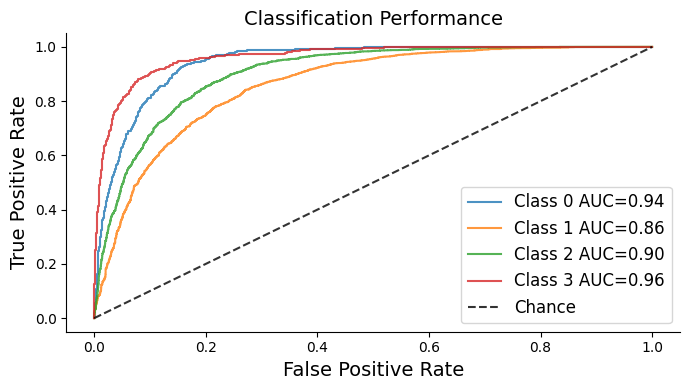

In [13]:
fig, ax = plt.subplots(figsize=(7, 4))

for i, (class_name, metrics) in enumerate(roc_results.items()):
    label = f"Class {i} AUC={metrics['roc_auc']:.2f}"
    plt.plot(metrics['fpr'], metrics['tpr'], lw=1.5, alpha=.8, label=label)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.title('Classification Performance', fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

## **Part D**: Inspect the trained model by analysing feature embeddings.

### Extract embeddings

We first need to extract the feature embeddings from the classification model.

**TASK:** Adapt the code below and make it work for your classification model. You only need to adapt the functions `on_test_epoch_start` and `test_step`.

In [25]:
# derived class to extract embeddings for visualization in addition to predictions
class MammoNetEmbeddings(MammoNet):
    def __init__(self, num_classes, learning_rate=0.0001):
        super().__init__(num_classes, learning_rate)
        self.embeddings = [] # list where we still store the embeddings

    def on_test_epoch_start(self):
        # self.model[-1] = nn.Identity(512) # replace final classification layer with identity to get embeddings
        # self.embeddings = [] # clear the list of embeddings at the start of testing

        self._orig_fc = self.model.fc
        self.model.fc = nn.Identity()
        self.embeddings = []

    def test_step(self, batch, batch_idx):
        # x = batch['image'].view(batch['image'].size(0), -1)
        # emb = self.model(x)
        # self.embeddings.append(emb.detach().cpu())

        x = batch["image"]      
        emb = self(x)               
        self.embeddings.append(emb.detach().cpu())

    # Override to disable other test logging of base class
    def on_test_epoch_end(self):
        return

In [26]:
def save_embeddings(model, output_fname):
    embeddings = torch.cat(model.embeddings, dim=0).cpu().numpy()
    df = pd.DataFrame(data=embeddings)
    df.to_csv(output_fname, index=False)

In [27]:
model_emb = MammoNetEmbeddings(num_classes=NUM_CLASSES)
trainer.test(model=model_emb, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
save_embeddings(model=model_emb, output_fname=os.path.join(output_dir, 'embeddings.csv'))

Restoring states from the checkpoint path at ./output/mammo-net/version_39/checkpoints/epoch=1-step=166.ckpt
Loaded model weights from the checkpoint at ./output/mammo-net/version_39/checkpoints/epoch=1-step=166.ckpt


Testing: |                                                                                                    …

### Model inspection

Now that we extracted the feature embeddings for the test set, we can combine this information with the meta data and the model predictions.

**TASK:** Adapt the provided code to conduct a model inspection, using different projections from different dimensionality reduction techniques, and overlay different types of meta information. Report the your findings in the coursework report. Note any interesting observations.

In [28]:
df_meta = pd.read_csv(CSV_FILE)
df_pred = pd.read_csv(os.path.join(output_dir, 'predictions.csv'))
df = pd.merge(df_pred, df_meta, how='inner', on=['image_id', 'study_id'])

In [29]:
embeddings = pd.read_csv(os.path.join(output_dir, 'embeddings.csv')).to_numpy()
print(embeddings.shape)

(5865, 512)


Next, we run PCA to reduce the dimenionality of the feature embeddings.

In [86]:
pca = decomposition.PCA(n_components=4, whiten=False)
embeddings_pca = pca.fit_transform(embeddings)

print(embeddings_pca.shape)

(5865, 4)


In [31]:
df['pca_1'] = embeddings_pca[:,0]
df['pca_2'] = embeddings_pca[:,1]
df['pca_3'] = embeddings_pca[:,2]
df['pca_4'] = embeddings_pca[:,3]

In [32]:
embeddings_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeddings_pca)

print(embeddings_tsne.shape)

(5865, 2)


In [33]:
df['tsne_1'] = embeddings_tsne[:,0]
df['tsne_2'] = embeddings_tsne[:,1]

df.head() # showing the first five entries in the dataframe

,class_0,class_1,class_2,class_3,target,study_id,image_id,laterality,view,age,...,implant,density,machine_id,split,pca_1,pca_2,pca_3,pca_4,tsne_1,tsne_2
0,0.000071,0.184287,0.815134,0.000508,2,10226,461614796,L,MLO,71.0,...,0,C,49,test,5.070624,7.230634,4.178161,0.149003,-8.337709,66.897675
1,0.000209,0.381038,0.618330,0.000423,2,10226,530620473,L,CC,71.0,...,0,C,49,test,2.577165,6.994522,2.421251,1.626428,-29.636503,23.277279
2,0.000659,0.448086,0.550242,0.001013,2,10226,309353373,R,CC,71.0,...,0,C,49,test,1.766452,5.842294,0.178963,0.703069,-43.116116,18.216566
3,0.000071,0.155826,0.843466,0.000637,2,10226,348710745,R,MLO,71.0,...,0,C,49,test,5.566581,6.887760,4.114919,-0.344176,-18.821352,59.699829
4,0.000109,0.175303,0.823764,0.000824,2,10226,806376890,R,MLO,71.0,...,0,C,49,test,5.172688,6.680535,3.325164,-0.520338,-20.466761,57.038944


In [34]:
## shuffle the dataframe to ensure random order of samples for visualization
df = df.sample(frac=1.0)

In [35]:
alpha = 0.6
style = '.'
markersize = 40
color_palette = 'tab10'
kind = 'scatter'

def plot_scatter(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

def plot_joint(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.jointplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette, marginal_kws={'common_norm': False})
    sns.move_legend(ax.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))

In [92]:
x = 'pca_1'
y = 'pca_2'

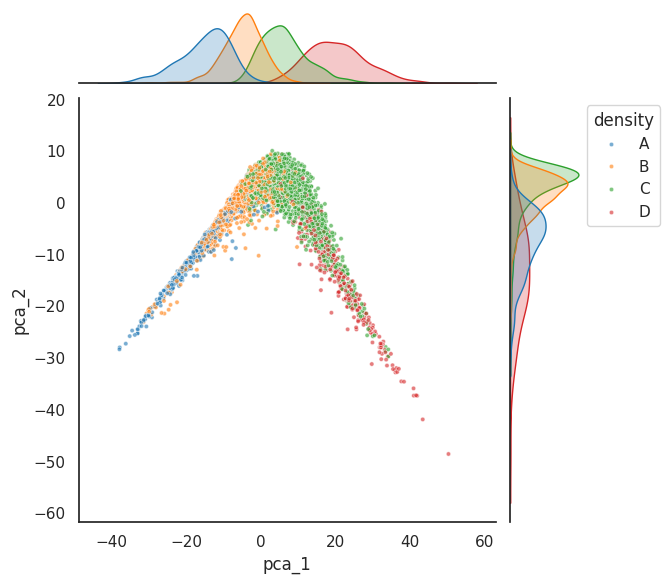

In [ ]:
plot_joint(df, 'implant', x, y, color_palette)

### Interactive visualisation

With the code below you can interactively explore the latent space to better understand how samples are distributed. You can modify the code to overlay different types of meta information.

In [60]:
df["image_path"] = [
    os.path.join("images", str(df.study_id.values[idx]), str(df.image_id.values[idx]) + ".png")
    for idx in range(len(df))
]

# df['color_label'] = 0
# df.loc[df['density'] == 'A', 'color_label'] = 0
# df.loc[df['density'] == 'B', 'color_label'] = 1
# df.loc[df['density'] == 'C', 'color_label'] = 2
# df.loc[df['density'] == 'D', 'color_label'] = 3

df['color_label'] = 0
df.loc[df['implant'] == '0', 'color_label'] = 0
df.loc[df['implant'] == '1', 'color_label'] = 1


In [61]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

color = cm.tab10(np.linspace(0, 1, 10))
colorlist = [(np.array(mpl.colors.to_rgb(c))*255).astype(int).tolist() for c in color]*10

colors = [rgb_to_hex(colorlist[c]) for c in df.color_label.values]

In [62]:
def preprocess(image):
    # breast mask
    image_norm = image - np.min(image)
    image_norm = image_norm / np.max(image_norm)
    thresh = cv2.threshold(img_as_ubyte(image_norm), 5, 255, cv2.THRESH_BINARY)[1]

    # Connected components with stats.
    nb_components, output, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=4)

    # Find the largest non background component.
    # Note: range() starts from 1 since 0 is the background label.
    max_label, _ = max(
        [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)],
        key=lambda x: x[1],
    )
    mask = output == max_label
    image_masked = image.copy()
    image_masked[mask == 0] = 0

    return image_masked

In [64]:
out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    sample = df.iloc[points.point_inds[0]]
    img_orig = imread(os.path.join(DATA_DIR, sample.image_path))
    img_proc = preprocess(img_orig)
    
    s = [6] * len(df)
    for i in points.point_inds:
        s[i] = 12
    with fig.batch_update():
        scatter.marker.size = s

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.imshow(img_orig, cmap='gray')
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(img_proc, cmap='gray')
    ax2.set_title('processed')
    ax2.axis('off')
    plt.show(f)
    
fig = go.FigureWidget(px.scatter(df, x=x, y=y, template='simple_white', hover_data={'implant': True, x:False, y:False}))
fig.update_layout(width=600, height=600)
scatter = fig.data[0]
scatter.on_click(handle_click)
scatter.marker.size = [6] * len(df)
scatter.marker.color = colors

HBox([fig, out])

    'data': [{'customdata': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAA…